# Goals

This notebook aims to demonstrate the usage of function calling capability of popular LLMs such as ones from OpenAI. 

In this demo, I'm using latest OpenAI model, GPT-4o, which is a multimodal model that combines both vision and text capabilities.
*Note: Audio capability announced by OpenAI isn't currently (27th of July 2024) supported yet in Azure OpenAI Service.*

This demo makes GPT-4o acting like an expense report assistant that can do multiple things like retrieving expense report ID, create a new expense report, add an expense to an existing report. These "skills" are made thanks to **function calling** capability of major Generative AI model providers like OpenAI, Mistral AI, and others.

I'm adding a speech capability at the end of the demo (for the 3rd expense), leveraging Azure Speech service which ables the user to do Speech-to-Text which feds the LLM prompt.

In [19]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
from IPython.display import display, HTML, Image
import json
import base64

load_dotenv("azure.env")
    
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),  
    api_version="2024-02-01",
    azure_endpoint = os.getenv("AZURE_OPENAI_API_BASE")
)

In [20]:
import pandas as pd
import numpy as np
import azure.cognitiveservices.speech as speechsdk
import random

def generate_unique_id(df, column_name):  
    while True:  
        random_id = random.randint(1, 10000)
        if random_id not in df[column_name].values:  
            return random_id

def recognize_from_microphone():
    # This example requires environment variables named "SPEECH_KEY" and "SPEECH_REGION"
    speech_config = speechsdk.SpeechConfig(subscription=os.environ.get('SPEECH_KEY'), region=os.environ.get('SPEECH_REGION'))
    speech_config.speech_recognition_language="en-US"

    audio_config = speechsdk.audio.AudioConfig(use_default_microphone=True)
    speech_recognizer = speechsdk.SpeechRecognizer(speech_config=speech_config, audio_config=audio_config)

    print("Speak into your microphone.")
    speech_recognition_result = speech_recognizer.recognize_once_async().get()

    if speech_recognition_result.reason == speechsdk.ResultReason.RecognizedSpeech:
        print("Recognized: {}".format(speech_recognition_result.text))
        return speech_recognition_result.text
    elif speech_recognition_result.reason == speechsdk.ResultReason.NoMatch:
        print("No speech could be recognized: {}".format(speech_recognition_result.no_match_details))
    elif speech_recognition_result.reason == speechsdk.ResultReason.Canceled:
        cancellation_details = speech_recognition_result.cancellation_details
        print("Speech Recognition canceled: {}".format(cancellation_details.reason))
        if cancellation_details.reason == speechsdk.CancellationReason.Error:
            print("Error details: {}".format(cancellation_details.error_details))
            print("Did you set the speech resource key and region values?")

In [21]:
df = pd.DataFrame(columns=['expense_report_id', 'title', 'payment_amount', 'currency', 'expense_report_month_year', 'receipts_attached', 'approval_status'])
df

,expense_report_id,title,payment_amount,currency,expense_report_month_year,receipts_attached,approval_status


In [22]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def retrieve_expense_report_id(df, expense_report_month_year):
    if expense_report_month_year in df.expense_report_month_year.values:
        return json.dumps({'expense_report_id': df[df.expense_report_month_year == expense_report_month_year].expense_report_id.values[0]}, cls=NpEncoder)
    else:
        return "There's no expense report yet for this date."
    
def create_expense_report(df, expense_report_id, title, amount, currency, expense_report_month_year):
    unique_id = generate_unique_id(df, 'expense_report_id')  
    new_row = {  
        'expense_report_id': unique_id,  
        'title': title, 
        'payment_amount': amount,
        'currency': currency,
        'expense_report_month_year': expense_report_month_year,
        'receipts_attached': 'Yes',
        'approval_status': 'Draft'  
    }
    df.loc[len(df)] = new_row
    return json.dumps({'expense_report_id': unique_id})

def add_expense_to_report(df, expense_report_id, amount):
    expense_report_id = float(expense_report_id)
    if expense_report_id in df.expense_report_id.values:
        existing_amount = float(df.loc[df.expense_report_id == expense_report_id, 'payment_amount'].values[0])
        new_amount = existing_amount + float(amount)
        df.loc[df.expense_report_id == expense_report_id, 'payment_amount'] = new_amount
        return json.dumps({'expense_report_id': expense_report_id})
    else:
        return "There's no expense report with this ID."
    
tools = [
    {
        "type": "function",
        "function": {
            "name": "retrieve_expense_report_id",
            "description": f"""
                Retrieves expense report ID - if it exists - the receipt belongs to. 
                Each expense report belongs to a specific month in a year.
                Example: Expense Report '5' gathers all receipts that are from 01/06/2024 to 30/06/2024.
                If for instance, the receipt is from 11/07/2024, and the expense report doesn't exist, ask the user if he wants to create a new one.
                If the expense report already exists say it to the user, return the expense report ID and ask the user if he wants to add this expense to the expense report. 
                """,
            "parameters": {
                "type": "object",
                "properties": {
                    "expense_report_month_year": {
                        "type": "string",
                        "description": "The month and year the receipt belongs to. For instance, if it's written 11/07/2024, then the month is '07-2024'."
                    }
                },
                "required": ["expense_report_month_year"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "create_expense_report",
            "description": f"""
                Create an expense report ID with the date (MM-YYYY), the amount of the receipt, the currency of the expense, the purpose of the expense, and the merchant name.
                """,
            "parameters": {
                "type": "object",
                "properties": {
                    "expense_report_month_year": {
                        "type": "string",
                        "description": "The month and year the receipt belongs to. For instance, if it's written 11/07/2024, then the month is 'July-2024'."
                    },
                    "amount": {
                        "type": "string",
                        "description": "The amount of the receipt (without the currency as this is done in another parameter)e.g. 12.5."
                    },
                    "currency": {
                        "type": "string",
                        "description": "The currency of the amount e.g. EUR, USD, GBP, JPY, etc."
                    },
                    "title": {
                        "type": "string",
                        "description": "The category of the expense report e.g. 'Customer workshop 24 June 2024'."
                    },
                    "expense_report_id": {
                        "type": "string",
                        "description": "The ID of the expense report."
                    },
                },
                "required": ["expense_report_month_year", "amount", "currency", "title", "expense_report_id"]
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "add_expense_to_report",
            "description": f"""
                Add the amount of the receipt to the expense report ID.
                """,
            "parameters": {
                "type": "object",
                "properties": {
                    "expense_report_id": {
                        "type": "string",
                        "description": "The ID of the expense report."
                    },
                    "amount": {
                        "type": "string",
                        "description": "The amount of the receipt (without the currency as this is done in another parameter)e.g. 12.5."
                    }
                },
                "required": ["expense_report_id", "amount"]
            },
        },
    }
]

import functools

names_to_functions = {
  'retrieve_expense_report_id': functools.partial(retrieve_expense_report_id, df=df),
  'create_expense_report': functools.partial(create_expense_report, df=df),
  'add_expense_to_report': functools.partial(add_expense_to_report, df=df)
}

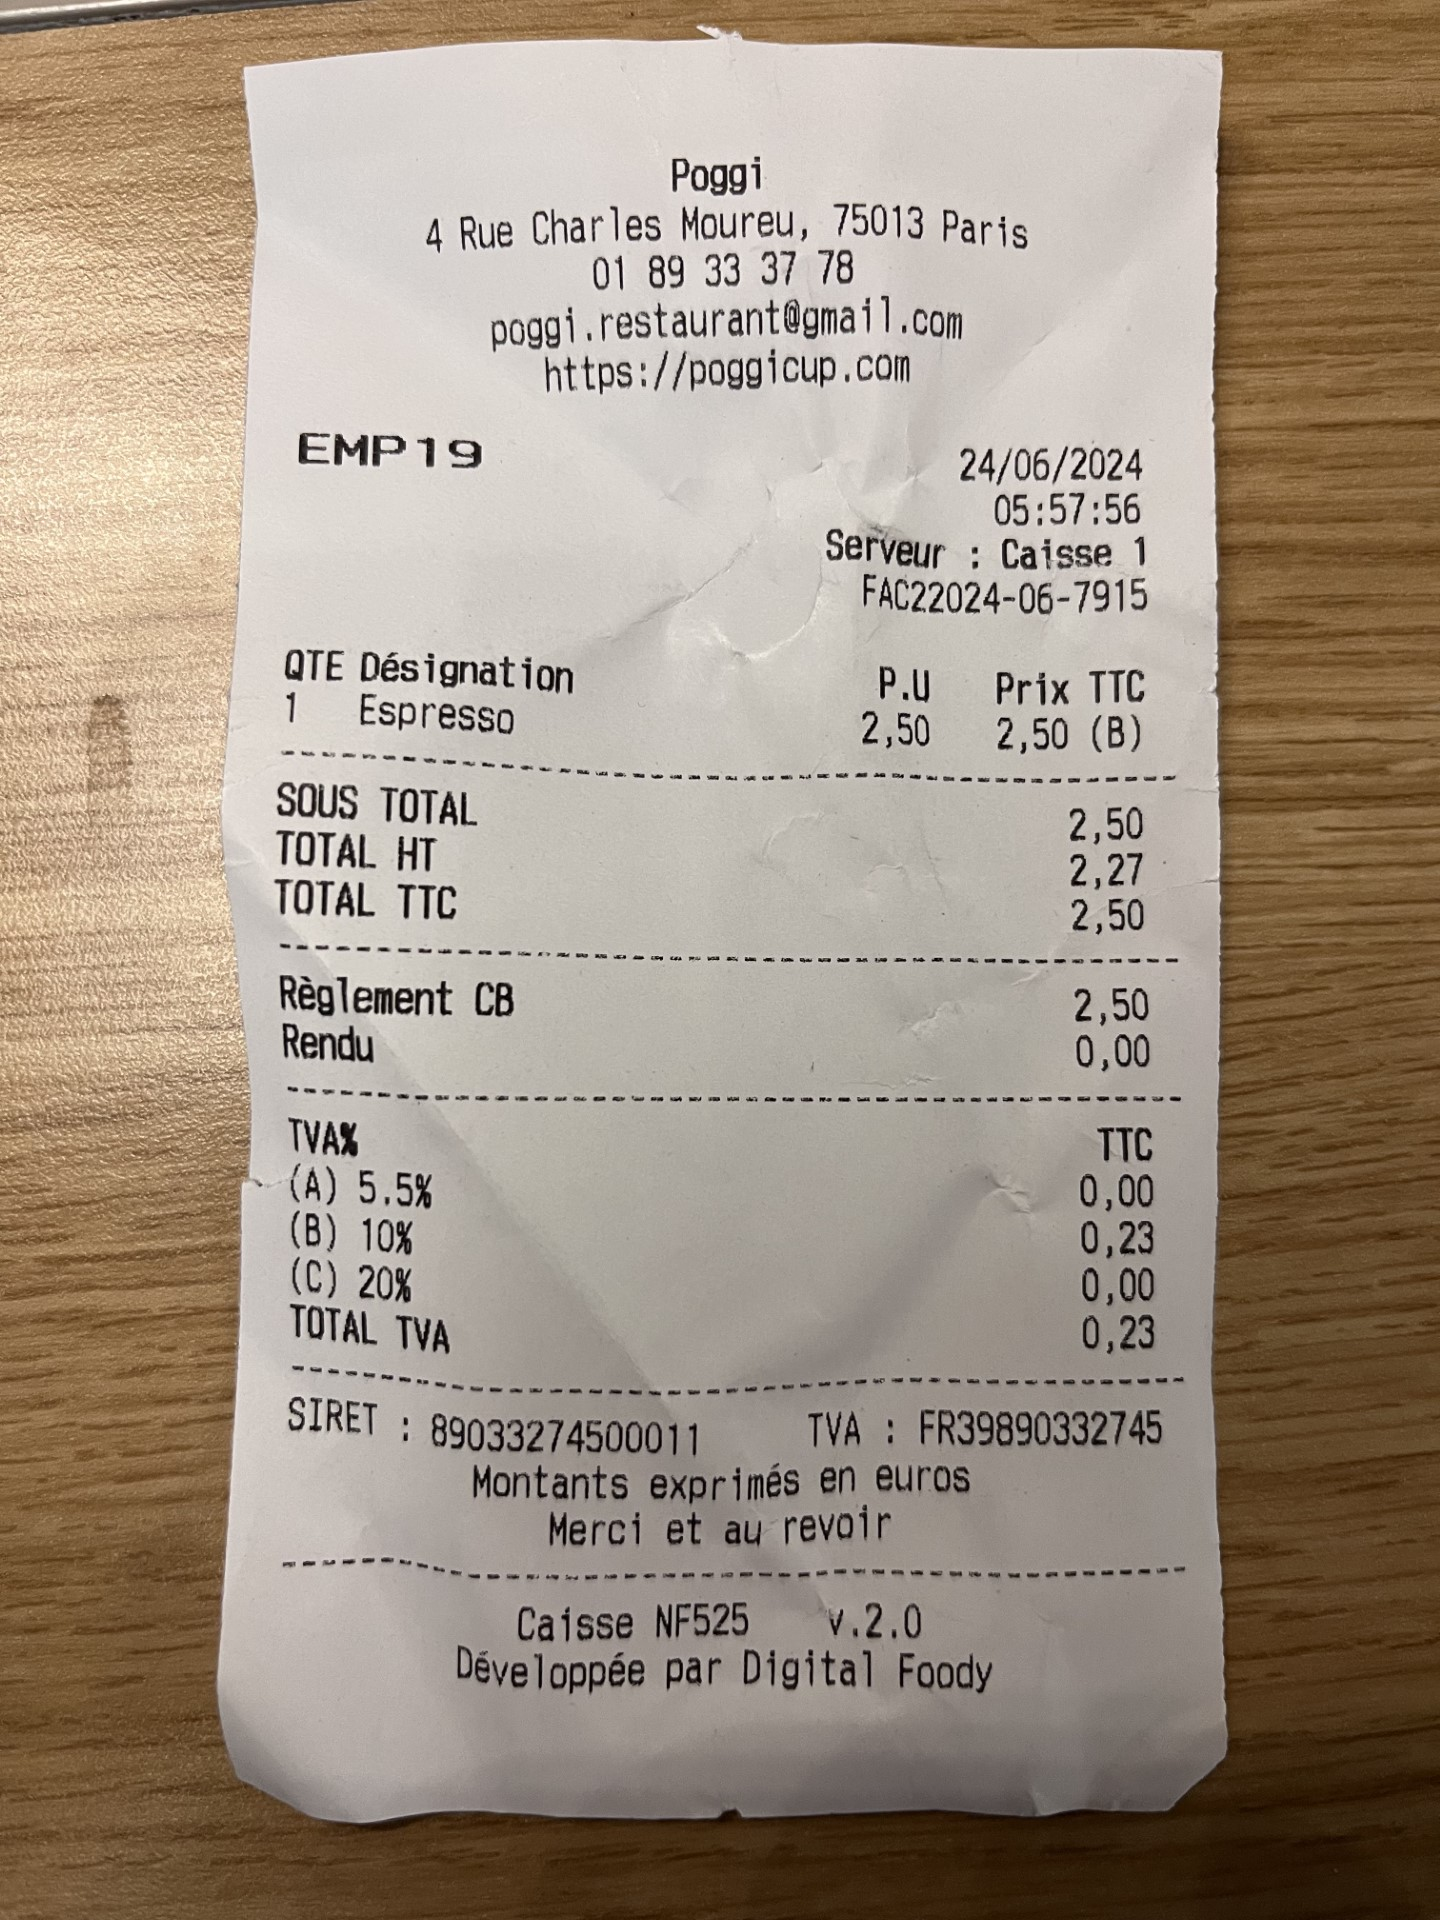

In [23]:
# Encoding the images to send to GPT-4o
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

expense_path = "data/receipt_1.jpg"
base64_image = encode_image(expense_path)

Image(filename=expense_path)

In [24]:
messages = [
    {"role": "system", "content": f"""
        You are an expense report assistant, equipped to analyze images of receipt. 
        Based on the user's request, use your tools (either to retrieve or create an expense report) to assist the user.
        In the receipts, interpret the date with the following format DD/MM/YYYY.
        Do not talk in the same language of the receipt, you have to answer in the same language as the user's request.
        """},
    {"role": "user", "content": [
        {"type": "text", "content": "I'm travelling today to visit my customer for a generative AI workshop. Please add this expense."},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]}
]

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages,
    tools=tools,
    tool_choice="auto",
)
response

ChatCompletion(id='chatcmpl-9egHGYRVmkmDxrIlwgp09ontYFW4p', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content="The receipt you provided is from Poggi dated 24th June 2024, and the total amount is EUR 2.50. \n\nI will check if there's an existing expense report for June 2024.", role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_WXDYi1tq0sxGWJcCp03vzt1G', function=Function(arguments='{"expense_report_month_year":"06-2024"}', name='retrieve_expense_report_id'), type='function')]))], created=1719482662, model='gpt-4o-2024-05-13', object='chat.completion', service_tier=None, system_fingerprint='fp_abc28019ad', usage=CompletionUsage(completion_tokens=68, prompt_tokens=1157, total_tokens=1225))

In [25]:
messages.append(response.choices[0].message)
# messages

In [26]:
tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)


function_name:  retrieve_expense_report_id 
function_params:  {'expense_report_month_year': '06-2024'}


In [27]:
function_result = names_to_functions[function_name](**function_params)
function_result

"There's no expense report yet for this date."

In [28]:
messages.append({
    "role": "tool",
    "tool_call_id": tool_call.id,
    "name": function_name,
    "content": function_result    
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages
)

messages.append(response.choices[0].message)
# messages

In [29]:
prompt = "Yes please."
messages.append({
    "role": "user",
    "content": prompt
})
# messages

In [30]:
response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages,
    tools=tools,
    tool_choice="auto"
)

response.choices[0].message.content
messages.append(response.choices[0].message)
# messages

In [31]:
tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)


function_name:  create_expense_report 
function_params:  {'expense_report_month_year': 'June-2024', 'amount': '2.50', 'currency': 'EUR', 'title': 'Business Expenses June 2024', 'expense_report_id': 'expense_june_2024'}


In [32]:
function_result = names_to_functions[function_name](**function_params)
function_result

'{"expense_report_id": 6703}'

In [33]:
messages.append({
    "role": "tool",
    "tool_call_id": tool_call.id,
    "name": function_name,
    "content": function_result    
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages
)

messages.append(response.choices[0].message)
# messages

In [34]:
print(response.choices[0].message.content)
df

The new expense report for June 2024 has been created with the ID 6703. I will now add the details of the receipt to this report.


,expense_report_id,title,payment_amount,currency,expense_report_month_year,receipts_attached,approval_status
0,6703,Business Expenses June 2024,2.50,EUR,June-2024,Yes,Draft


In [35]:
expense_path = "data/receipt_2.jpg"
base64_image = encode_image(expense_path)

Image(filename=expense_path)

prompt = "Add this new expense."
messages.append({
    "role": "user",
    "content": [
        {"type": "text", "content": prompt},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages,
    tools=tools,
    tool_choice="auto"
)

response.choices[0].message.content
messages.append(response.choices[0].message)

tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)

function_result = names_to_functions[function_name](**function_params)
function_result

messages.append({
    "role": "tool",
    "tool_call_id": tool_call.id,
    "name": function_name,
    "content": function_result    
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages
)

print(response.choices[0].message.content)
df


function_name:  add_expense_to_report 
function_params:  {'expense_report_id': '6703', 'amount': '3.40'}
The expense of EUR 3.40 has been successfully added to the expense report for June 2024 (ID: 6703).

Is there anything else you need assistance with?


,expense_report_id,title,payment_amount,currency,expense_report_month_year,receipts_attached,approval_status
0,6703,Business Expenses June 2024,5.9,EUR,June-2024,Yes,Draft


In [36]:
expense_path = "data/receipt_3.jpg"
base64_image = encode_image(expense_path)

Image(filename=expense_path)

messages.append({
    "role": "user",
    "content": [
        {"type": "text", "content": recognize_from_microphone()},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages,
    tools=tools,
    tool_choice="auto"
)

response.choices[0].message.content
messages.append(response.choices[0].message)

tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)

function_result = names_to_functions[function_name](**function_params)
function_result

messages.append({
    "role": "tool",
    "tool_call_id": tool_call.id,
    "name": function_name,
    "content": function_result    
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages
)

print(response.choices[0].message.content)
df

Speak into your microphone.
Recognized: Please add this new expense.

function_name:  retrieve_expense_report_id 
function_params:  {'expense_report_month_year': '10-2023'}
There is no existing expense report for October 2023. I will create a new expense report for this month.

Here is the information from the receipt that will be added to the report:

- **Date:** 09/10/2023
- **Merchant:** Bistrot Aurelie
- **Address:** 40 Rue Saint Remi, 33000 Bordeaux, France
- **Total Amount:** EUR 26.15

I will proceed with creating the new expense report.


,expense_report_id,title,payment_amount,currency,expense_report_month_year,receipts_attached,approval_status
0,6703,Business Expenses June 2024,5.9,EUR,June-2024,Yes,Draft


In [37]:
expense_path = "data/receipt_3.jpg"
base64_image = encode_image(expense_path)

Image(filename=expense_path)

messages.append({
    "role": "user",
    "content": [
        {"type": "text", "content": recognize_from_microphone()},
        {"type": "image_url", "image_url": {
            "url": f"data:image/png;base64,{base64_image}"}
        }
    ]
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages,
    tools=tools,
    tool_choice="auto"
)

response.choices[0].message.content
messages.append(response.choices[0].message)

tool_call = response.choices[0].message.tool_calls[0]
function_name = tool_call.function.name
function_params = json.loads(tool_call.function.arguments)
print("\nfunction_name: ", function_name, "\nfunction_params: ", function_params)

function_result = names_to_functions[function_name](**function_params)
function_result

messages.append({
    "role": "tool",
    "tool_call_id": tool_call.id,
    "name": function_name,
    "content": function_result    
})

response = client.chat.completions.create(
    model="gpt-4o",
    messages = messages
)

print(response.choices[0].message.content)
df

Speak into your microphone.
Recognized: Yes please. You can create a new expense report.

function_name:  create_expense_report 
function_params:  {'expense_report_month_year': 'October-2023', 'amount': '26.15', 'currency': 'EUR', 'title': 'Business Expenses October 2023', 'expense_report_id': 'expense_october_2023'}
A new expense report for October 2023 has been created with the ID 1893. The details from the Bistrot Aurelie receipt have been added to this expense report.

Is there anything else you need assistance with?


,expense_report_id,title,payment_amount,currency,expense_report_month_year,receipts_attached,approval_status
0,6703,Business Expenses June 2024,5.9,EUR,June-2024,Yes,Draft
1,1893,Business Expenses October 2023,26.15,EUR,October-2023,Yes,Draft
